heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448   -7.618048 ]
 [-13.04684    -9.590575 ]
 [ -8.764083  -12.284308 ]
 ...
 [-21.287073   -1.4127754]
 [-22.94848    -2.2394783]
 [-22.354143   -5.196636 ]]
43200004
epoch number 1,rmse_x=9.999 μm,rmse_y=14.077 μm


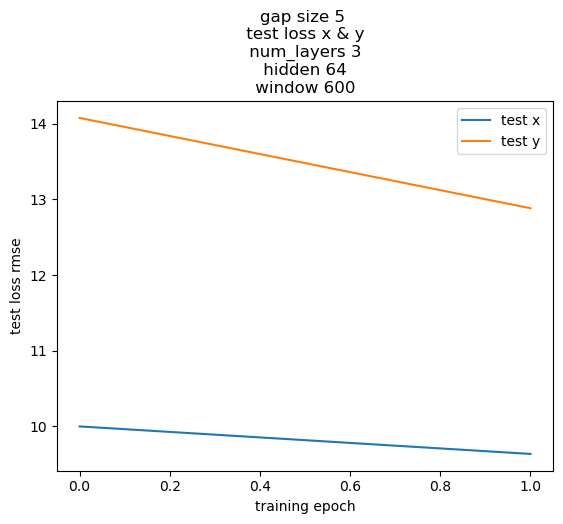

epoch number 1,rmse_x=8.061 μm,rmse_y=14.175 μm


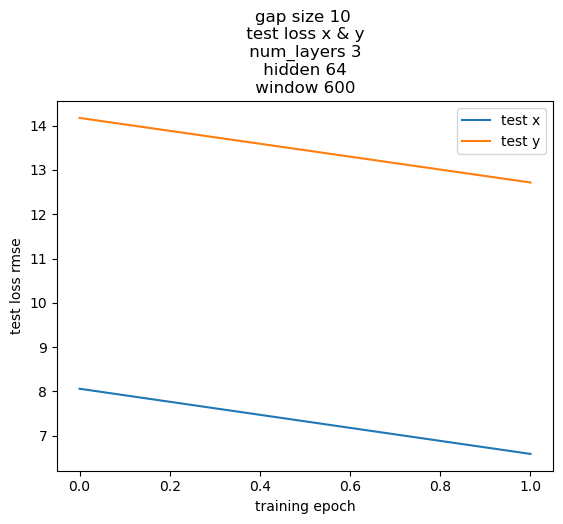

epoch number 1,rmse_x=10.459 μm,rmse_y=12.214 μm


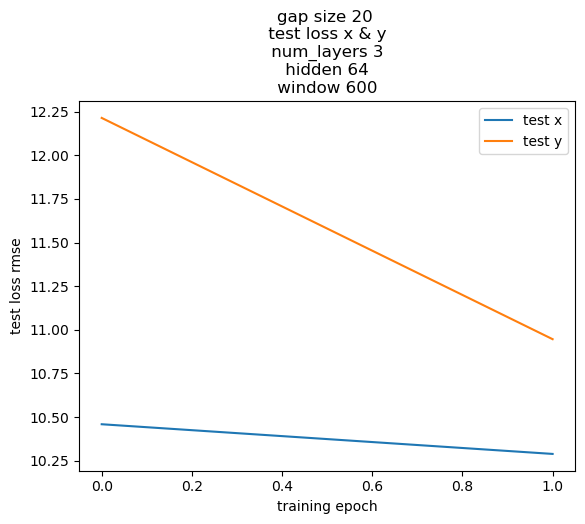

In [8]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
#our_data = reduced_size= our_data[:10000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think
# Keep the entire dataset, but subsample randomly from within it during training.
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

class OurJitterDataset():
    def __init__(self,data,window,gap):
        self.data=data
        self.window=window
        self.gap=gap
        self.N = data.shape[0] # The true length of the dataset
        

    def __len__(self): #i use this s.t. i can run .random_split down below
        #return len(self.data)-self.window-self.gap #also this makes it so we dont go outside the data!
        return 10000 # Only let the trainer take 10000 before declaring the epoch "finished"
        
    def __getitem__(self,idx):
        i = torch.randint(0, self.N - self.window - self.gap -1, (1,)).item() # Pick a random starting point
        input= torch.tensor(self.data[i:i+self.window], dtype=torch.float32) #thisll b 600,2
        output=torch.tensor( self.data[i+self.window+self.gap], dtype=torch.float32) #thisll b 2,. the output prediction
        return input,output



for gap in [5,10,20]:

    #hyperparams to keep fixed
    epochs= 2 #if it doesnt converge, i gotta adjust
    batch_siz= 128 #just depending on speed mostly, big minib. faster
    lr=.002

    #the 3 hyperparams to vary
    num_layers=3
    hidden=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
    window=600
    #lets create a class to return input and output data 

   
    #load up the data
    our_dataset = OurJitterDataset(our_data,window,gap)
    train_size=int(.8*len(our_dataset))
        
    train_data,test_data= torch.utils.data.random_split(our_dataset,[train_size,len(our_dataset)-train_size])
    train_loader= DataLoader(train_data,batch_size=batch_siz,shuffle=True)
    test_loader= DataLoader(test_data,batch_size=batch_siz,shuffle=True)

    # MODELS ########################
    #### LSTM
    #lets roll out the model
    class OurLSTM(nn.Module):
        def __init__(self, hidden, num_layers):
            super().__init__()
            self.lstm=nn.LSTM(2,hidden_size=hidden, num_layers=num_layers,batch_first=True)
            self.out_proj=nn.Linear(hidden,2)

        def forward(self,x):
            output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)  #
            return self.out_proj(final_hidden_state[-1]) #last layer hidden state, equiv to [0] for us cuz we just have 1 layer
    #### LSTM+CNN
    class OurCNNLSTM(nn.Module):
        def __init__(self, hidden, num_layers):
            super().__init__()
            self.conv= nn.Conv1d(2,32,kernel_size=5,padding=2)  
            self.lstm= nn.LSTM(32,hidden_size=hidden,num_layers=num_layers,batch_first=True)
            self.out_proj= nn.Linear(hidden, 2)
        
        def forward(self, x):
            x= x.permute(0,2,1)        
            x= torch.relu(self.conv(x))  
            x= x.permute(0,2,1)      
            output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)
            return self.out_proj(final_hidden_state[-1])
    #### TRANSF
    class OurTransformer(nn.Module):
        def __init__(self, hidden, num_layers):
            super().__init__()
            self.input_proj=nn.Linear(2,hidden)
            encoder_layer=nn.TransformerEncoderLayer(d_model=hidden,nhead=4,batch_first=True)
            self.transformer= nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
            self.out_proj= nn.Linear(hidden,2)
        
        def forward(self,x):
            x= self.input_proj(x)         
            x= self.transformer(x)         
            return self.out_proj(x[:, -1])   #last timestep
    # -------------------------------------------
    our_model=OurLSTM(hidden,num_layers)###########################################here!!!!!!!!!!
    optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
    loss = nn.MSELoss()
    rmse_list_x=[]
    rmse_list_y=[]

    for epoch in range(epochs):
        our_model.train()
        for inp,target in train_loader:
            pred=our_model(inp)
            l=loss(pred, target)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        our_model.eval()
        errors=[]
        with torch.no_grad():
            for inp,target in test_loader:
                pred= our_model(inp)
                errors.append((pred-target).numpy())
        errors=np.concatenate(errors)
        rmse_x= np.sqrt((errors[:,0]**2).mean())
        rmse_y= np.sqrt((errors[:,1]**2).mean())
        rmse_list_x.append(rmse_x)
        rmse_list_y.append(rmse_y)
        if epoch%10==0:
            print(f"epoch number {epoch+1},rmse_x={rmse_x:.3f} μm,rmse_y={rmse_y:.3f} μm")

    fig=plt.figure()
    ax=fig.add_subplot()
    ax.plot(rmse_list_x,label="test x")
    ax.plot(rmse_list_y,label="test y")
    ax.legend()
    ax.set_xlabel("training epoch")
    ax.set_ylabel("test loss rmse")
    ax.set_title(f"gap size {gap} \n test loss x & y \n num_layers {num_layers} \n hidden {hidden} \n window {window} ")
    plt.show()

### experimenting with various architectures beyond MLP :-)
##############################################################
#### 1. LSTM
#### 2. CNN + LSTM
#### 3. Transformer
##############################################################
### for each of these, i'll vary: 
#### 1. num_layers
#### 2. hidden size (aka dimensionality)
#### 3. Input window length (150,300,600)... it could be that too many time-samples cause overfitting
##############################################################
#####   technically, we could do a grid search and try like 3 combos of each hyperparam, i.e. 3x3x3=27 runs for each architecture type
#####   however, i'll just run "fix and vary". it's unlikely that there are interactions here between the hyperparams


In [ ]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
our_data = reduced_size= our_data[:10000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think

In [20]:
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448    -7.618048  ]
 [-13.04684     -9.590575  ]
 [ -8.764083   -12.284308  ]
 ...
 [ -0.63192445   1.02285   ]
 [  3.8037598    1.02285   ]
 [  8.485918     0.28353426]]
1000


In [21]:
#hyperparams to keep fixed
epochs= 100 #if it doesnt converge, i gotta adjust
batch_siz= 128 #just depending on speed mostly, big minib. faster
gap=20
lr=.002

#the 3 hyperparams to vary
num_layers=3
hidden=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
window=600

In [22]:
#lets create a class to return input and output data 

class OurJitterDataset():
    def __init__(self,data,window,gap):
        self.data=data
        self.window=window
        self.gap=gap

    def __len__(self): #i use this s.t. i can run .random_split down below
        return len(self.data)-self.window-self.gap #also this makes it so we dont go outside the data!
    
    def __getitem__(self,i):
        input= torch.tensor(self.data[i:i+self.window], dtype=torch.float32) #thisll b 600,2
        output=torch.tensor( self.data[i+self.window+self.gap], dtype=torch.float32) #thisll b 2,. the output prediction
        return input,output

In [23]:
#load up the data
our_dataset = OurJitterDataset(our_data,window,gap)
train_size=int(.8*len(our_dataset))
    
train_data,test_data= torch.utils.data.random_split(our_dataset,[train_size,len(our_dataset)-train_size])
train_loader= DataLoader(train_data,batch_size=batch_siz,shuffle=True)
test_loader= DataLoader(test_data,batch_size=batch_siz,shuffle=True)


# MODELS ########################

#### LSTM

In [24]:
#lets roll out the model
class OurLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.lstm=nn.LSTM(2,hidden_size=hidden, num_layers=num_layers,batch_first=True)
        self.out_proj=nn.Linear(hidden,2)

    def forward(self,x):
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)  #
        return self.out_proj(final_hidden_state[-1]) #last layer hidden state, equiv to [0] for us cuz we just have 1 layer

#### LSTM+CNN

In [25]:
class OurCNNLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.conv= nn.Conv1d(2,32,kernel_size=5,padding=2)  
        self.lstm= nn.LSTM(32,hidden_size=hidden,num_layers=num_layers,batch_first=True)
        self.out_proj= nn.Linear(hidden, 2)
    
    def forward(self, x):
        x= x.permute(0,2,1)        
        x= torch.relu(self.conv(x))  
        x= x.permute(0,2,1)      
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)
        return self.out_proj(final_hidden_state[-1])

#### TRANSF

In [26]:
class OurTransformer(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.input_proj=nn.Linear(2,hidden)
        encoder_layer=nn.TransformerEncoderLayer(d_model=hidden,nhead=4,batch_first=True)
        self.transformer= nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
        self.out_proj= nn.Linear(hidden,2)
    
    def forward(self,x):
        x= self.input_proj(x)         
        x= self.transformer(x)         
        return self.out_proj(x[:, -1])   #last timestep

# -------------------------------------------

In [27]:
our_model=OurTransformer(hidden,num_layers)
optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
loss = nn.MSELoss()

In [28]:
rmse_list_x=[]
rmse_list_y=[]

for epoch in range(epochs):
    our_model.train()
    for inp,target in train_loader:
        pred=our_model(inp)
        l=loss(pred, target)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    our_model.eval()
    errors=[]
    with torch.no_grad():
        for inp,target in test_loader:
            pred= our_model(inp)
            errors.append((pred-target).numpy())
    errors=np.concatenate(errors)
    rmse_x= np.sqrt((errors[:,0]**2).mean())
    rmse_y= np.sqrt((errors[:,1]**2).mean())
    rmse_list_x.append(rmse_x)
    rmse_list_y.append(rmse_y)
    print(f"epoch number {epoch+1},rmse_x={rmse_x:.3f} μm,rmse_y={rmse_y:.3f} μm")



fig=plt.figure()
ax=fig.add_subplot()
ax.plot(rmse_list_x,label="test x")
ax.plot(rmse_list_y,label="test y")
ax.legend()
ax.set_xlabel("training epoch")
ax.set_ylabel("test loss rmse")
ax.set_title(f"test loss x & y \n num_layers {num_layers} \n hidden {hidden} \n window {window} ")

epoch number 1,rmse_x=8.185 μm,rmse_y=9.739 μm


KeyboardInterrupt: 